In [1]:
import torch
import torch.nn as nn
from PIL import Image
from gsplat.rendering import rasterization
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from diffusers import EulerAncestralDiscreteScheduler
from einops import rearrange
import numpy as np
from zuko.utils import odeint
from tqdm import tqdm

device = 'cuda'

In [2]:
class FlowModel(nn.Module):

    def forward(self, X, time):
        raise NotImplementedError()
    

class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        emb = self.freqs * t[..., None]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class FlowNeuralNetwork(FlowModel):

    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features)


    def forward(self, X, time):
        X = torch.cat([X, self.time_embedding(time)], axis=1)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

In [3]:
width = 256
height = 256
n_gaussians = 100
num_cams = 1
means = torch.rand((n_gaussians, 3), device=device)
quats = torch.rand((n_gaussians, 4), device=device)
quats = quats / torch.linalg.norm(quats, dim=1, keepdim=True)
scales = torch.rand((n_gaussians, 3), device=device)
colors = torch.rand((n_gaussians, 3), device=device)
opacities = torch.rand((n_gaussians,), device=device)
camtoworlds = torch.tensor(
            [
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -3.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            ],
            device=device,
        )
fov_x = math.pi / 2.0
focal = 0.5 * float(width) / math.tan(0.5 * fov_x)
Ks = torch.tensor(
            [
                [focal, 0, width / 2],
                [0, focal, height / 2],
                [0, 0, 1],
            ],
            device=device,
        )

Ks = Ks[None].repeat(num_cams, 1, 1)

colors.requires_grad = True
means.requires_grad = True
scales.requires_grad = True
quats.requires_grad = True
optimizer = torch.optim.Adam(
            [colors, means, scales, opacities, quats], 0.01
        )


In [4]:
img = np.array(Image.open('/home/ubuntu/gsplats-expr/abstr.jpeg').resize((256, 256)))

In [5]:
img_t = torch.tensor(img / 255)[None].to(device)

In [6]:
# render_colors, render_alphas, info = rasterization(
#             means=means,
#             quats=quats,
#             scales=scales,
#             opacities=opacities,
#             colors=colors,
#             viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
#             Ks=Ks,  # [C, 3, 3]
#             width=width,
#             height=height,
#             packed=False,
#             absgrad=True,
#             sparse_grad=False,
#             rasterize_mode="antialiased",
#         )

In [7]:
max_steps = 20000
renders = []

for step_id in range(max_steps):
    optimizer.zero_grad()
    render_colors, render_alphas, info = rasterization(
                means=means,
                quats=quats / torch.linalg.norm(quats, dim=1, keepdim=True),
                scales=scales,
                opacities=opacities,
                colors=colors,
                viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
                Ks=Ks,  # [C, 3, 3]
                width=width,
                height=height,
                packed=False,
                absgrad=True,
                sparse_grad=False,
                rasterize_mode="antialiased",
            )
    renders.append(render_colors[0])
    loss = torch.nn.MSELoss()(render_colors.float(), img_t.float())

    loss.backward()
    optimizer.step()
    if step_id % 500 == 0:
        print(loss.item())

0.27531698346138
0.042600926011800766
0.034730374813079834
0.032486580312252045
0.030707385390996933
0.029493724927306175
0.028119085356593132
0.027334129437804222
0.028173163533210754
0.029494931921362877
0.027865007519721985
0.027531100437045097
0.027646033093333244
0.02775154635310173
0.026686932891607285
0.026235327124595642
0.02716219425201416
0.02645544521510601
0.026000475510954857
0.0261729396879673
0.025375593453645706
0.02549836039543152
0.02513442002236843
0.025423472747206688
0.02486182563006878
0.025258973240852356
0.024911262094974518
0.025034857913851738
0.02499905601143837
0.024951186031103134
0.025339767336845398
0.024759311228990555
0.024822261184453964
0.024790039286017418
0.024890750646591187
0.024382559582591057
0.024911997839808464
0.024663766846060753
0.025324594229459763
0.024925194680690765


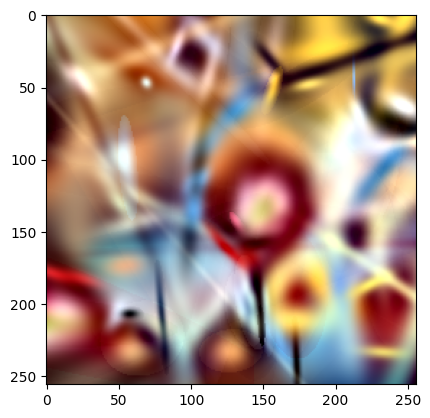

In [8]:
plt.imshow((torch.clamp(render_colors[0], 0, 1).cpu().data.numpy() * 255).astype(np.uint8))

In [9]:
colors.shape, means.shape, scales.shape, quats.shape

(torch.Size([100, 3]),
 torch.Size([100, 3]),
 torch.Size([100, 3]),
 torch.Size([100, 4]))

In [10]:
torch.cat([colors, means, scales, quats], dim=-1).shape

torch.Size([100, 13])

In [11]:
def conditional_flow_matching_loss(flow_model, x):
    sigma_min = 1e-4
    t = torch.rand(x.shape[0], device=x.device)
    noise = torch.randn_like(x)

    x_t = (1 - (1 - sigma_min) * t[:, None]) * noise + t[:, None] * x
    optimal_flow = x - (1 - sigma_min) * noise
    predicted_flow = flow_model(x_t, time=t)

    return (predicted_flow - optimal_flow).square().mean()

model = FlowNeuralNetwork(n_features=13, n_blocks=10, time_embedding_size=32).cuda().train()
optimizer = torch.optim.AdamW(model.parameters())
target = torch.cat([colors, means, scales, quats], dim=-1)

for epoch in range(30_000):
    model.zero_grad()
    loss = conditional_flow_matching_loss(model, target)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(epoch, loss.item())

model = model.eval()

0 141.45127868652344


500 7.64793586730957
1000 8.04296875
1500 5.294491291046143
2000 4.863320827484131
2500 4.320164680480957
3000 4.390805244445801
3500 7.8057332038879395
4000 5.471287727355957
4500 4.903781414031982
5000 5.060871124267578
5500 3.5706114768981934
6000 4.39484167098999
6500 7.763777732849121
7000 5.126803874969482
7500 17.070301055908203
8000 4.071589469909668
8500 3.8236613273620605
9000 4.6221160888671875
9500 5.51910924911499
10000 12.24246597290039
10500 3.325380802154541
11000 6.646327972412109
11500 3.070713996887207
12000 2.703461170196533
12500 2.6112546920776367
13000 2.890211343765259
13500 6.075384616851807
14000 2.5889127254486084
14500 3.2575430870056152
15000 5.0438971519470215
15500 3.2233386039733887
16000 5.299360752105713
16500 4.451000690460205
17000 9.352392196655273
17500 3.8067781925201416
18000 4.63775110244751
18500 8.533594131469727
19000 4.779545307159424
19500 2.7721731662750244
20000 4.819614887237549
20500 2.8810031414031982
21000 3.1361448764801025
21500 5.1

In [32]:
num_steps = 4
out = torch.randn_like(target)
sigma_min = 1e-4

for k in range(num_steps):
    t = torch.linspace(0, 1, num_steps)[k]
    time = torch.ones_like(target)[:, 0] * t

    out = model(out, time)

In [34]:
colors_pred, means_pred, scales_pred, quats_pred = out[:, :3], out[:, 3:6], out[:, 6:9], out[:, 9:]

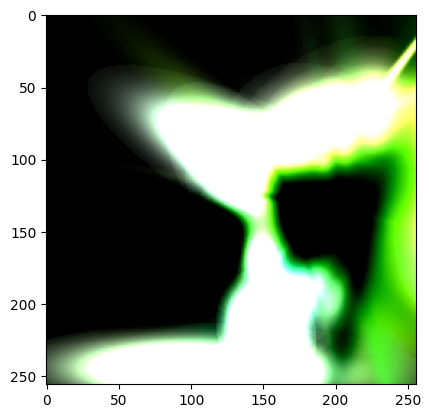

In [35]:
render_colors, render_alphas, info = rasterization(
            means=means_pred,
            quats=quats_pred,
            scales=scales_pred,
            opacities=opacities,
            colors=colors_pred,
            viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
            Ks=Ks,  # [C, 3, 3]
            width=width,
            height=height,
            packed=False,
            absgrad=True,
            sparse_grad=False,
            rasterize_mode="antialiased",
        )

plt.imshow((torch.clamp(render_colors[0], 0, 1).cpu().data.numpy() * 255).astype(np.uint8))